In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_15827/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


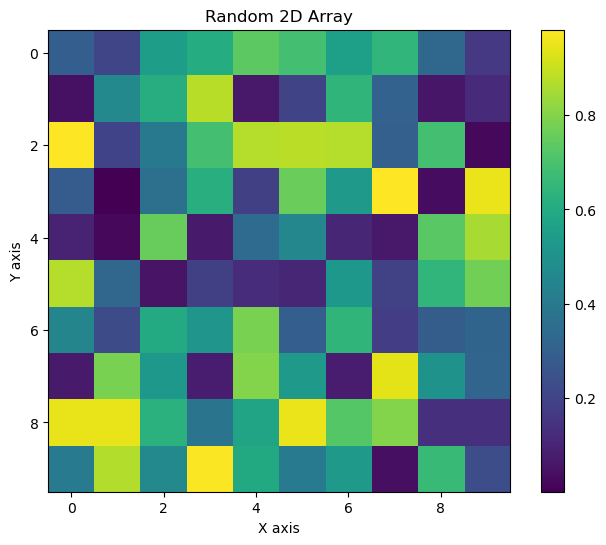

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
# ### my_snn control board ########################
# decay = 0.4 # 0.875 0.25 0.125 0.75 0.5
# # nda 0.25 # ottt 0.5
# const2 = True # trace 할거면 True, 안할거면 False

# unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
# run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

# if const2 == True:
#     const2 = decay
# else:
#     const2 = 0.0

# wandb.init(project= f'my_snn {unique_name}',save_code=True)

# my_snn_system(  devices = "2",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = 64, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = 'DVS_GESTURE_TONIC',
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',512],
#                 cfg = ['M','M',200,200],
#                 # cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = 0.005, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = 300,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = 'rectangle', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = 5, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = False, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                
#                 ) 
# # sigmoid와 BN이 있어야 잘된다.
# # average pooling
# # 이 낫다. 
 
# # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
# ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# # DDP 실행 코드
# '''
# ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
# CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
# CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
# CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
# '''


In [6]:
# sweep 하는 코드, 위 셀 주석처리 해야 됨.

# 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

unique_name_hyper = 'main'
run_name = 'main'
sweep_configuration = {
    'method': 'bayes',
    'name': f'my_snn_sweep{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}',
    'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
    'parameters': 
    {
        "learning_rate": {"values": [0.009]},
        "BATCH": {"values": [64]},
        "decay": {"values": [0.5]},
        "IMAGE_SIZE": {"values": [128]},
        "TIME": {"values": [10]},
        "epoch_num": {"values": [15]},
        "dvs_duration": {"values": [25_000]},
        "dvs_clipping": {"values": [1,2,3,4,5,6]},
        "which_data": {"values": ['DVS_GESTURE_TONIC']},
        "OTTT_sWS_on": {"values": [False]},
        "const2": {"values": [False]},
        "surrogate": {"values": ['rectangle', 'sigmoid', 'hard_sigmoid']},
        "DFA_on": {"values": [False]},
        "OTTT_input_trace_on": {"values": [False]},
        "cfg": {"values": [['M','M',200,200]]},
     }
}

def hyper_iter():
    ### my_snn control board ########################
    unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
    wandb.init(save_code = True)
    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.BATCH
    decay  =  wandb.config.decay
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    TIME  =  wandb.config.TIME
    epoch_num  =  wandb.config.epoch_num 
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    which_data  =  wandb.config.which_data
    OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
    const2  =  wandb.config.const2
    surrogate  =  wandb.config.surrogate
    DFA_on  =  wandb.config.DFA_on
    OTTT_input_trace_on  =  wandb.config.OTTT_input_trace_on
    cfg  =  wandb.config.cfg

    if const2 == True:
        const2 = decay
    else:
        const2 = 0.0

    my_snn_system(  devices = "2",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = which_data,
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',200,200],
                # cfg = [200,200],
                cfg = cfg,
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = epoch_num,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                
                    ) 
    # sigmoid와 BN이 있어야 잘된다.
    # average pooling
    # 이 낫다. 
    
    # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
    ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=10000, project=f'my_snn {unique_name_hyper}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: lxogzess
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/my_snn%20main/sweeps/lxogzess


wandb: Agent Starting Run: xpeaygew with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002058029174805, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.458598136901855 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.090486526489258, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.59047055244446 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.008610954559391704'], iter_loss:24.04264259338379, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]  

epoch_time: 46.0516197681427 seconds

EPOCH 3



3-16/17 iter:5.66%, lr=['0.008140576474687264'], iter_loss:24.001314163208008, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.827327728271484 seconds

EPOCH 4



4-16/17 iter:5.66%, lr=['0.007511087728614862'], iter_loss:24.04475975036621, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.530643939971924 seconds

EPOCH 5



5-16/17 iter:3.77%, lr=['0.00675'], iter_loss:24.04197883605957, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]  

epoch_time: 47.48469161987305 seconds

EPOCH 6



6-16/17 iter:7.55%, lr=['0.005890576474687264'], iter_loss:23.977964401245117, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.41370487213135 seconds

EPOCH 7



7-16/17 iter:5.66%, lr=['0.0049703780847044415'], iter_loss:23.9934024810791, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]   

epoch_time: 46.689231872558594 seconds

EPOCH 8



8-16/17 iter:5.66%, lr=['0.00402962191529556'], iter_loss:24.019758224487305, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it]

epoch_time: 43.230547189712524 seconds

EPOCH 9



9-16/17 iter:9.43%, lr=['0.0031094235253127374'], iter_loss:24.023500442504883, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.41594076156616 seconds

EPOCH 10



10-16/17 iter:7.55%, lr=['0.002250000000000001'], iter_loss:23.979433059692383, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it] 

epoch_time: 41.42365598678589 seconds

EPOCH 11



11-16/17 iter:9.43%, lr=['0.0014889122713851394'], iter_loss:23.980257034301758, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.05216956138611 seconds

EPOCH 12



12-16/17 iter:5.66%, lr=['0.0008594235253127369'], iter_loss:23.97300910949707, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]  

epoch_time: 45.653144121170044 seconds

EPOCH 13



13-16/17 iter:3.77%, lr=['0.0003890454406082956'], iter_loss:23.991300582885742, tr:7.24%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.72434401512146 seconds

EPOCH 14



14-16/17 iter:11.32%, lr=['9.83357966978744e-05'], iter_loss:23.96980094909668, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 


epoch_time: 45.29234480857849 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▅▄▄▆▁▆▅▅▂▁▅▅▄▅▅█▂▄▄▃▂▃▆▅▃▅▁▃▅▃▂▆▁▆▃▅▂▄▂
summary_val_acc,▁▁▁█████████████████████████████████████
tr_acc,▁▁▁▇▇██████▇▇███▇▇▇▇▇▇▇▇████████▇▇▇██▇▇▇
val_acc_best,▁▁▁█████████████████████████████████████
val_acc_now,▁▁▁█████████████████████████████████████
epoch,14
iter_acc,0.11321
tr_acc,0.08821
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: y7zv4ehu with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002058029174805, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.62997770309448 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.090486526489258, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.61258912086487 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.008610954559391704'], iter_loss:24.04264259338379, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]  

epoch_time: 46.62717533111572 seconds

EPOCH 3



3-16/17 iter:5.66%, lr=['0.008140576474687264'], iter_loss:24.001314163208008, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.0571711063385 seconds

EPOCH 4



4-16/17 iter:5.66%, lr=['0.007511087728614862'], iter_loss:24.04475975036621, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 44.06428337097168 seconds

EPOCH 5



5-16/17 iter:3.77%, lr=['0.00675'], iter_loss:24.04197883605957, tr:7.71%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]  

epoch_time: 47.36453437805176 seconds

EPOCH 6



6-16/17 iter:7.55%, lr=['0.005890576474687264'], iter_loss:23.977964401245117, tr:6.87%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.65698051452637 seconds

EPOCH 7



7-16/17 iter:5.66%, lr=['0.0049703780847044415'], iter_loss:23.9934024810791, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]   

epoch_time: 48.19983458518982 seconds

EPOCH 8



8-16/17 iter:5.66%, lr=['0.00402962191529556'], iter_loss:24.019758224487305, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.310210943222046 seconds

EPOCH 9



9-16/17 iter:9.43%, lr=['0.0031094235253127374'], iter_loss:24.023500442504883, tr:8.45%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 45.08328938484192 seconds

EPOCH 10



10-16/17 iter:7.55%, lr=['0.002250000000000001'], iter_loss:23.979433059692383, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it] 

epoch_time: 42.06804966926575 seconds

EPOCH 11



11-16/17 iter:9.43%, lr=['0.0014889122713851394'], iter_loss:23.980257034301758, tr:7.34%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.05510187149048 seconds

EPOCH 12



12-16/17 iter:5.66%, lr=['0.0008594235253127369'], iter_loss:23.97300910949707, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]  

epoch_time: 45.04511213302612 seconds

EPOCH 13



13-16/17 iter:3.77%, lr=['0.0003890454406082956'], iter_loss:23.991300582885742, tr:7.24%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.681546688079834 seconds

EPOCH 14



14-16/17 iter:11.32%, lr=['9.83357966978744e-05'], iter_loss:23.96980094909668, tr:8.82%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it] 


epoch_time: 45.138859272003174 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▅▄▄▆▁▆▅▅▂▁▅▅▄▅▅█▂▄▄▃▂▃▆▅▃▅▁▃▅▃▂▆▁▆▃▅▂▄▂
summary_val_acc,▁▁▁█████████████████████████████████████
tr_acc,▁▁▁▇▇██████▇▇███▇▇▇▇▇▇▇▇████████▇▇▇██▇▇▇
val_acc_best,▁▁▁█████████████████████████████████████
val_acc_now,▁▁▁█████████████████████████████████████
epoch,14
iter_acc,0.11321
tr_acc,0.08821
val_acc_best,0.09091
val_acc_now,0.09091


wandb: Agent Starting Run: 7gvobkwy with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.82377576828003 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.232133626937866 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it]

epoch_time: 45.13426399230957 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.51905965805054 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.33843374252319 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 44.983553409576416 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.93510603904724 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.94577431678772 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it] 

epoch_time: 44.177993297576904 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.280247926712036 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.886460065841675 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.61281418800354 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 45.102494955062866 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.53801202774048 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


epoch_time: 45.381040811538696 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: hz3vluc6 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.74624586105347 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.367106914520264 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.27400875091553 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.57853627204895 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.72103309631348 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.97668981552124 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it] 

epoch_time: 45.26906228065491 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.65446472167969 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it] 

epoch_time: 44.13387393951416 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.46061563491821 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.29372477531433 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.55519366264343 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.413331270217896 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.5246844291687 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]


epoch_time: 46.17454266548157 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: dmfch0ue with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.748549938201904 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.69786190986633 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.19593524932861 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.49958109855652 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.75559163093567 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.54704189300537 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.540563106536865 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.71180438995361 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.51000714302063 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.030983209609985 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.326133489608765 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.63885188102722 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.649561166763306 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.82551646232605 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


epoch_time: 45.32628011703491 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 75rgishe with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.06549143791199 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.464210987091064 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.23729419708252 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.55323362350464 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.28508377075195 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.33020377159119 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.83521819114685 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.02567005157471 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it] 

epoch_time: 43.21514654159546 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.339229106903076 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.035120248794556 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.075836420059204 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.84971785545349 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.30931091308594 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]


epoch_time: 47.35878086090088 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: lf45ddm7 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:23.89552116394043, tr:7.89%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.04373359680176 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:18.14860725402832, tr:29.06%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.764402627944946 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.874113082885742, tr:42.99%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.625990867614746 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:14.600987434387207, tr:48.65%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.114479541778564 seconds

EPOCH 4



4-16/17 iter:50.94%, lr=['0.007511087728614862'], iter_loss:13.40589427947998, tr:56.92%, val:48.48%, val_best:49.62%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.84267854690552 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:9.663277626037598, tr:62.86%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.95148015022278 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.005890576474687264'], iter_loss:10.714981079101562, tr:63.51%, val:50.76%, val_best:52.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.29449486732483 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0049703780847044415'], iter_loss:10.388936996459961, tr:68.15%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.99024486541748 seconds

EPOCH 8



8-16/17 iter:69.81%, lr=['0.00402962191529556'], iter_loss:10.725500106811523, tr:72.33%, val:51.14%, val_best:53.03%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.05050873756409 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:9.273694038391113, tr:75.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.51144814491272 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.215263366699219, tr:77.62%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

epoch_time: 42.23828077316284 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:8.50782585144043, tr:79.39%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it] 

epoch_time: 41.37345552444458 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.218794822692871, tr:80.41%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.34577918052673 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.52436351776123, tr:80.22%, val:57.95%, val_best:58.71%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]  

epoch_time: 45.07987833023071 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:11.00831127166748, tr:80.69%, val:57.58%, val_best:58.71%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]


epoch_time: 46.011953353881836 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▅▅▅▅▄▅▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.79245
tr_acc,0.80687
val_acc_best,0.58712
val_acc_now,0.57576


wandb: Agent Starting Run: n1t7efrz with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.2421441078186 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.774131059646606 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.32008719444275 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.9636754989624 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.07699799537659 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.50694131851196 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:56<00:00,  3.33s/it] 

epoch_time: 56.704530477523804 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:56<00:00,  3.32s/it]

epoch_time: 56.58527588844299 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [01:05<00:00,  3.85s/it] 

epoch_time: 65.65463256835938 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:56<00:00,  3.30s/it]

epoch_time: 56.23957395553589 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.43950128555298 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.193480014801025 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.6287407875061 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 44.990397691726685 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]


epoch_time: 45.33897852897644 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: wbbugzl0 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.38393950462341 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.544453859329224 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.758352279663086 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.31209635734558 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.899779081344604 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.76432943344116 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.50992202758789 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.454951763153076 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.868948459625244 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.82s/it]

epoch_time: 48.157052516937256 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.79480314254761 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.445087909698486 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.92645883560181 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.94268584251404 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


epoch_time: 45.73618841171265 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: fq8ozjbn with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.179792165756226 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 44.98278546333313 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.62004995346069 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.428739070892334 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.83608841896057 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.912779569625854 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.56335711479187 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.47628903388977 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.72623896598816 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.33567404747009 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.27547311782837 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.31983232498169 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.95252513885498 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.72218704223633 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]


epoch_time: 46.21215271949768 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 2txafrm3 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:19.908599853515625, tr:20.15%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.46802735328674 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:10.999921798706055, tr:45.13%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.46316480636597 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.008610954559391704'], iter_loss:14.642013549804688, tr:56.45%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.11633038520813 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.008140576474687264'], iter_loss:9.987695693969727, tr:61.37%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.88284182548523 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.580619812011719, tr:69.17%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.25998377799988 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00675'], iter_loss:6.74287748336792, tr:76.23%, val:58.33%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]  

epoch_time: 45.40990209579468 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:6.156121730804443, tr:81.34%, val:56.06%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 45.99994993209839 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0049703780847044415'], iter_loss:5.26284122467041, tr:85.42%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]  

epoch_time: 45.796201944351196 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:4.716041088104248, tr:92.57%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.909448862075806 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0031094235253127374'], iter_loss:2.686621904373169, tr:94.71%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.32171177864075 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.5359017848968506, tr:97.40%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

epoch_time: 42.280582904815674 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:2.4006283283233643, tr:97.68%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.96873593330383 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:1.6276766061782837, tr:98.24%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.47370171546936 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:1.4860150814056396, tr:98.98%, val:62.12%, val_best:67.80%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.2252094745636 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:2.011528968811035, tr:98.98%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]  


epoch_time: 45.23611760139465 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▄▅▅▆▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████████████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
epoch,14
iter_acc,0.96226
tr_acc,0.98979
val_acc_best,0.67803
val_acc_now,0.64015


wandb: Agent Starting Run: mwni7crd with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.291999101638794 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.45125412940979 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.69544267654419 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.55077242851257 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.81842303276062 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.69527769088745 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.34014940261841 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.14165449142456 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it] 

epoch_time: 43.181132555007935 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.90850377082825 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.77318024635315 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 40.00005555152893 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.40435981750488 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.01196599006653 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]


epoch_time: 45.993577003479004 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 8mkdv1hv with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:23.89552116394043, tr:7.89%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.2182514667511 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:18.14860725402832, tr:29.06%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.361233711242676 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.874113082885742, tr:42.99%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.558300733566284 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:14.600987434387207, tr:48.65%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.557602882385254 seconds

EPOCH 4



4-16/17 iter:50.94%, lr=['0.007511087728614862'], iter_loss:13.40589427947998, tr:56.92%, val:48.48%, val_best:49.62%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it] 

epoch_time: 42.19603729248047 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:9.663277626037598, tr:62.86%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.38542866706848 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.005890576474687264'], iter_loss:10.714981079101562, tr:63.51%, val:50.76%, val_best:52.27%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.280425786972046 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0049703780847044415'], iter_loss:10.388936996459961, tr:68.15%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.75452375411987 seconds

EPOCH 8



8-16/17 iter:69.81%, lr=['0.00402962191529556'], iter_loss:10.725500106811523, tr:72.33%, val:51.14%, val_best:53.03%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.50610542297363 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:9.273694038391113, tr:75.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.56750965118408 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.215263366699219, tr:77.62%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.25312685966492 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:8.50782585144043, tr:79.39%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.781205892562866 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.218794822692871, tr:80.41%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.80203318595886 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.52436351776123, tr:80.22%, val:57.95%, val_best:58.71%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]  

epoch_time: 45.914530754089355 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:11.00831127166748, tr:80.69%, val:57.58%, val_best:58.71%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]


epoch_time: 46.39130520820618 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▅▅▅▅▄▅▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.79245
tr_acc,0.80687
val_acc_best,0.58712
val_acc_now,0.57576


wandb: Agent Starting Run: xununpu1 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.00206184387207, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.49981212615967 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.089448928833008, tr:8.17%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.833935022354126 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.008610954559391704'], iter_loss:24.042566299438477, tr:8.64%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.9068021774292 seconds

EPOCH 3



3-16/17 iter:5.66%, lr=['0.008140576474687264'], iter_loss:24.001272201538086, tr:7.89%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.434659004211426 seconds

EPOCH 4



4-16/17 iter:5.66%, lr=['0.007511087728614862'], iter_loss:24.04482078552246, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it] 

epoch_time: 41.81354784965515 seconds

EPOCH 5



5-16/17 iter:5.66%, lr=['0.00675'], iter_loss:24.006174087524414, tr:8.36%, val:10.61%, val_best:10.61%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.21995234489441 seconds

EPOCH 6



6-16/17 iter:13.21%, lr=['0.005890576474687264'], iter_loss:23.635011672973633, tr:11.23%, val:13.64%, val_best:13.64%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.20374774932861 seconds

EPOCH 7



7-16/17 iter:18.87%, lr=['0.0049703780847044415'], iter_loss:23.142719268798828, tr:13.09%, val:14.39%, val_best:14.39%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.5232458114624 seconds

EPOCH 8



8-16/17 iter:28.30%, lr=['0.00402962191529556'], iter_loss:20.563871383666992, tr:22.19%, val:20.83%, val_best:20.83%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.97832107543945 seconds

EPOCH 9



9-16/17 iter:37.74%, lr=['0.0031094235253127374'], iter_loss:19.83026885986328, tr:28.04%, val:31.06%, val_best:31.06%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.578120946884155 seconds

EPOCH 10



10-16/17 iter:39.62%, lr=['0.002250000000000001'], iter_loss:18.028705596923828, tr:34.73%, val:32.95%, val_best:32.95%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.50108194351196 seconds

EPOCH 11



11-16/17 iter:49.06%, lr=['0.0014889122713851394'], iter_loss:16.953826904296875, tr:42.43%, val:38.64%, val_best:38.64%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.39845013618469 seconds

EPOCH 12



12-16/17 iter:49.06%, lr=['0.0008594235253127369'], iter_loss:18.297584533691406, tr:50.23%, val:39.39%, val_best:39.39%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.02749705314636 seconds

EPOCH 13



13-16/17 iter:54.72%, lr=['0.0003890454406082956'], iter_loss:17.559612274169922, tr:52.00%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.77557587623596 seconds

EPOCH 14



14-16/17 iter:43.40%, lr=['9.83357966978744e-05'], iter_loss:18.952571868896484, tr:53.11%, val:42.80%, val_best:42.80%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it]


epoch_time: 45.106663942337036 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▂▁▂▂▂▁▁▂▂▂▂▂▃▁▂▃▃▃▄▃▄▅▅▄▆▅▆▆▆▇██▆█▇▇
summary_val_acc,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▆▆▆▇▇▇▇▇▇█████
tr_acc,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇█████
val_acc_best,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▆▆▆▇▇▇▇▇▇█████
val_acc_now,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▆▆▆▇▇▇▇▇▇█████
epoch,14
iter_acc,0.43396
tr_acc,0.5311
val_acc_best,0.42803
val_acc_now,0.42803


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 37x5l023 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.80039024353027 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.01030373573303 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.89432406425476 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.50781512260437 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.44868493080139 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.274486780166626 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.28048634529114 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.383973836898804 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.5080931186676 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 44.99443435668945 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.25971269607544 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.2759051322937 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.845850706100464 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.74236273765564 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


epoch_time: 45.64679408073425 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 1f3498vp with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.164984941482544 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.86802339553833 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.67729616165161 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.62310528755188 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.29383087158203 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it] 

epoch_time: 45.16920852661133 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.49570560455322 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.32526993751526 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.58405804634094 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.80964660644531 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.80151629447937 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 40.15427279472351 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.45611023902893 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.655357122421265 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]


epoch_time: 47.54219055175781 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: ql7krlxc with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]

epoch_time: 44.647862672805786 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.49474883079529 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.57075119018555 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.33731389045715 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.877148151397705 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.32493591308594 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.36779308319092 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.25301694869995 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.55585765838623 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.65s/it]

epoch_time: 45.13531804084778 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.764373540878296 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.70632338523865 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.7283821105957 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.09251546859741 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


epoch_time: 45.66060733795166 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: ndp5uets with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.2230110168457 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 43.96789193153381 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.917009353637695 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.40831017494202 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.663477659225464 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it] 

epoch_time: 45.978683948516846 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.32055449485779 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.56171727180481 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it] 

epoch_time: 45.22046518325806 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.79874539375305 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.783703565597534 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.133647203445435 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.18988347053528 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.81694459915161 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it]


epoch_time: 44.618276834487915 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: jaaovxxx with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:19.908599853515625, tr:20.15%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:45<00:00,  2.71s/it]

epoch_time: 46.15520405769348 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:10.999921798706055, tr:45.13%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.88832974433899 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.008610954559391704'], iter_loss:14.642013549804688, tr:56.45%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.056280851364136 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.008140576474687264'], iter_loss:9.987695693969727, tr:61.37%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.243732213974 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.580619812011719, tr:69.17%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.73546481132507 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00675'], iter_loss:6.74287748336792, tr:76.23%, val:58.33%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]  

epoch_time: 45.51045298576355 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:6.156121730804443, tr:81.34%, val:56.06%, val_best:59.47%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.53635025024414 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0049703780847044415'], iter_loss:5.26284122467041, tr:85.42%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]  

epoch_time: 46.92601156234741 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:4.716041088104248, tr:92.57%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.68448805809021 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0031094235253127374'], iter_loss:2.686621904373169, tr:94.71%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.682263135910034 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.5359017848968506, tr:97.40%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it]

epoch_time: 43.11379265785217 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:2.4006283283233643, tr:97.68%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it] 

epoch_time: 41.02815246582031 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:1.6276766061782837, tr:98.24%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.84222912788391 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:1.4860150814056396, tr:98.98%, val:62.12%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.46232533454895 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:2.011528968811035, tr:98.98%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]  


epoch_time: 46.70717144012451 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▄▅▅▆▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████████████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
epoch,14
iter_acc,0.96226
tr_acc,0.98979
val_acc_best,0.67803
val_acc_now,0.64015


wandb: Agent Starting Run: eo35wjwv with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.44678068161011 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.244367599487305 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.181644678115845 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.77922558784485 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.00783371925354 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.516552209854126 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.25573945045471 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.14479207992554 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.46764779090881 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.37697196006775 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.73175263404846 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 40.003358125686646 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.65403985977173 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 45.99488830566406 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]


epoch_time: 45.63301706314087 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 2pkyoh8q with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.37657117843628 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.84311556816101 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.45176434516907 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.96332263946533 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:42<00:00,  2.49s/it]

epoch_time: 42.504327058792114 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.79015374183655 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.85822010040283 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.75874900817871 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.66218829154968 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.574357748031616 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.16267371177673 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.26987934112549 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.66801905632019 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.842443227767944 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]


epoch_time: 47.28545141220093 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: aga173yp with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.83546257019043 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.11285209655762 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.77492046356201 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.55892777442932 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.25891661643982 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.698193073272705 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it] 

epoch_time: 47.69970226287842 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.32157373428345 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.78140354156494 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.87820506095886 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.413005352020264 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.90251398086548 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 46.986088037490845 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.649858474731445 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]


epoch_time: 46.75296878814697 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: g0xtdkxd with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.82545232772827 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.56837010383606 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.98522448539734 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.495128870010376 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.303508043289185 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.68073558807373 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.47213077545166 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.53419375419617 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it] 

epoch_time: 45.26662611961365 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.83438992500305 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.40770101547241 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.701839447021484 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.00726056098938 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.41055464744568 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]


epoch_time: 46.89289951324463 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: wwky3oca with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.535625457763672, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.403159379959106 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:15.336490631103516, tr:31.38%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.46827244758606 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.008610954559391704'], iter_loss:15.780881881713867, tr:48.19%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.48184275627136 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.602616310119629, tr:60.45%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.61273431777954 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007511087728614862'], iter_loss:9.887682914733887, tr:70.66%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:43<00:00,  2.53s/it] 

epoch_time: 43.18636870384216 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00675'], iter_loss:7.636259078979492, tr:75.95%, val:54.55%, val_best:57.20%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.457247734069824 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:7.104458332061768, tr:79.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.894328594207764 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.690909385681152, tr:87.28%, val:56.44%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.41961479187012 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.00402962191529556'], iter_loss:5.310471057891846, tr:91.09%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.01608896255493 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0031094235253127374'], iter_loss:3.8914525508880615, tr:94.71%, val:60.98%, val_best:61.36%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.9648118019104 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.002250000000000001'], iter_loss:4.201205730438232, tr:96.01%, val:60.61%, val_best:61.36%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.59799790382385 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.1933445930480957, tr:98.14%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.92121195793152 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.242617130279541, tr:98.14%, val:61.36%, val_best:62.12%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.29959011077881 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.5570783615112305, tr:98.51%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.774484634399414 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:3.5013153553009033, tr:98.51%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it] 


epoch_time: 48.64184808731079 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▄▄▅▆▆▅▆▇▆▆▆▇▆▇▇▇▇█████████████████
summary_val_acc,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,0.96226
tr_acc,0.98514
val_acc_best,0.62121
val_acc_now,0.60985


wandb: Agent Starting Run: fjucrxnh with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 5
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002058029174805, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.10321927070618 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.090486526489258, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.253535747528076 seconds

EPOCH 2



2-16/17 iter:9.43%, lr=['0.008610954559391704'], iter_loss:24.013282775878906, tr:8.45%, val:9.47%, val_best:9.47%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.49725937843323 seconds

EPOCH 3



3-16/17 iter:7.55%, lr=['0.008140576474687264'], iter_loss:23.906789779663086, tr:9.94%, val:11.74%, val_best:11.74%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.49331712722778 seconds

EPOCH 4



4-16/17 iter:7.55%, lr=['0.007511087728614862'], iter_loss:23.300323486328125, tr:13.83%, val:14.02%, val_best:14.02%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.88494920730591 seconds

EPOCH 5



5-16/17 iter:16.98%, lr=['0.00675'], iter_loss:21.74898338317871, tr:19.22%, val:16.29%, val_best:16.29%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 48.01861119270325 seconds

EPOCH 6



6-16/17 iter:24.53%, lr=['0.005890576474687264'], iter_loss:21.16873550415039, tr:23.21%, val:20.83%, val_best:20.83%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.19340109825134 seconds

EPOCH 7



7-16/17 iter:33.96%, lr=['0.0049703780847044415'], iter_loss:20.988903045654297, tr:28.69%, val:23.86%, val_best:23.86%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.44614577293396 seconds

EPOCH 8



8-16/17 iter:26.42%, lr=['0.00402962191529556'], iter_loss:19.976665496826172, tr:31.57%, val:28.41%, val_best:28.41%: 100%|██████████| 17/17 [00:45<00:00,  2.70s/it]

epoch_time: 46.157570123672485 seconds

EPOCH 9



9-16/17 iter:37.74%, lr=['0.0031094235253127374'], iter_loss:19.751853942871094, tr:36.21%, val:33.71%, val_best:33.71%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.572285413742065 seconds

EPOCH 10



10-16/17 iter:45.28%, lr=['0.002250000000000001'], iter_loss:18.015844345092773, tr:38.81%, val:28.79%, val_best:33.71%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.823246479034424 seconds

EPOCH 11



11-16/17 iter:41.51%, lr=['0.0014889122713851394'], iter_loss:18.537273406982422, tr:41.97%, val:34.09%, val_best:34.09%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.238314151763916 seconds

EPOCH 12



12-16/17 iter:49.06%, lr=['0.0008594235253127369'], iter_loss:19.973915100097656, tr:42.15%, val:32.58%, val_best:34.09%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]

epoch_time: 47.224040269851685 seconds

EPOCH 13



13-16/17 iter:50.94%, lr=['0.0003890454406082956'], iter_loss:20.0869140625, tr:43.55%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]     

epoch_time: 46.390085220336914 seconds

EPOCH 14



14-16/17 iter:32.08%, lr=['9.83357966978744e-05'], iter_loss:21.234600067138672, tr:44.01%, val:37.12%, val_best:37.12%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]


epoch_time: 47.57673239707947 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▂▁▂▂▂▁▂▂▂▄▃▄▅▃▄▅▅▅▄▅▅▆▆▆▇▅▇▆▆▇█▇▅█▇▆
summary_val_acc,▁▁▁▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▆▆▆▇▇▇▇▇███
tr_acc,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇████████
val_acc_best,▁▁▁▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇███
val_acc_now,▁▁▁▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▆▆▆▇▇▇▇▇███
epoch,14
iter_acc,0.32075
tr_acc,0.44011
val_acc_best,0.37121
val_acc_now,0.37121


wandb: Agent Starting Run: 624707o2 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.535625457763672, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.064857721328735 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:15.336490631103516, tr:31.38%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it]

epoch_time: 46.91333317756653 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.008610954559391704'], iter_loss:15.780881881713867, tr:48.19%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.18952393531799 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.602616310119629, tr:60.45%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.31440806388855 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007511087728614862'], iter_loss:9.887682914733887, tr:70.66%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it] 

epoch_time: 44.943089962005615 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00675'], iter_loss:7.636259078979492, tr:75.95%, val:54.55%, val_best:57.20%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.92590951919556 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:7.104458332061768, tr:79.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.39102005958557 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.690909385681152, tr:87.28%, val:56.44%, val_best:57.58%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.955413818359375 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.00402962191529556'], iter_loss:5.310471057891846, tr:91.09%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.48647880554199 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0031094235253127374'], iter_loss:3.8914525508880615, tr:94.71%, val:60.98%, val_best:61.36%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.55906820297241 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.002250000000000001'], iter_loss:4.201205730438232, tr:96.01%, val:60.61%, val_best:61.36%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.45038080215454 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.1933445930480957, tr:98.14%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.3321053981781 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.242617130279541, tr:98.14%, val:61.36%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.51968550682068 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.5570783615112305, tr:98.51%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.523741483688354 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:3.5013153553009033, tr:98.51%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 


epoch_time: 47.897359132766724 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▄▄▅▆▆▅▆▇▆▆▆▇▆▇▇▇▇█████████████████
summary_val_acc,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,0.96226
tr_acc,0.98514
val_acc_best,0.62121
val_acc_now,0.60985


wandb: Agent Starting Run: k6h3ioxw with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.27652287483215 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.021292209625244 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.73043990135193 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.332810401916504 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.314175605773926 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it] 

epoch_time: 47.09893536567688 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.90712928771973 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.14036774635315 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it] 

epoch_time: 46.339494466781616 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.748305320739746 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.86441206932068 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.97718834877014 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.55971670150757 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.80960822105408 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it]


epoch_time: 47.20770812034607 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: jf8o4bnj with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it]

epoch_time: 46.25759148597717 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]

epoch_time: 47.360278367996216 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.09197974205017 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.69960856437683 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.46384143829346 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it] 

epoch_time: 47.3519241809845 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:49<00:00,  2.88s/it] 

epoch_time: 49.183178424835205 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.7533597946167 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it] 

epoch_time: 46.685986280441284 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.890812397003174 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.82606863975525 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.25511646270752 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it] 

epoch_time: 49.6773407459259 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.68498396873474 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]


epoch_time: 49.520214319229126 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: hfenerla with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:47<00:00,  2.80s/it]

epoch_time: 47.84821033477783 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.190088510513306 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 48.941997051239014 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.263609409332275 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.663477659225464 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.07108926773071 seconds

EPOCH 6



6-11/17 iter:67.19%, lr=['0.005890576474687264'], iter_loss:9.006697654724121, tr:72.14%, val:58.33%, val_best:58.33%:  71%|███████   | 12/17 [00:26<00:09,  1.86s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it] 

epoch_time: 49.238481760025024 seconds

EPOCH 7



7-3/17 iter:81.25%, lr=['0.0049703780847044415'], iter_loss:7.397187232971191, tr:72.14%, val:54.92%, val_best:58.33%:  18%|█▊        | 3/17 [00:09<00:39,  2.85s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
7-15/17 iter:84.38%, lr=['0.0049703780847044415'], iter_loss:7.027831554412842, tr:72.14%, val:54.92%, val_best:58.33%:  88%|████████▊ | 15/17 [00:35<00:04,  2.29s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.48852896690369 seconds

EPOCH 8



8-8/17 iter:79.69%, lr=['0.00402962191529556'], iter_loss:6.388323783874512, tr:80.59%, val:60.98%, val_best:60.98%:  53%|█████▎    | 9/17 [00:23<00:19,  2.41s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.76418948173523 seconds

EPOCH 9



train:   0%|          | 0/17 [00:00<?, ?it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
9-9/17 iter:89.06%, lr=['0.0031094235253127374'], iter_loss:5.126517295837402, tr:84.77%, val:60.23%, val_best:60.98%:  59%|█████▉    | 10/17 [00:28<00:17,  2.51s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:55<00:00,  3.27s/it]

epoch_time: 55.71604299545288 seconds

EPOCH 10



10-0/17 iter:93.75%, lr=['0.002250000000000001'], iter_loss:5.600027084350586, tr:88.86%, val:60.23%, val_best:60.98%:   6%|▌         | 1/17 [00:03<00:54,  3.42s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
10-14/17 iter:93.75%, lr=['0.002250000000000001'], iter_loss:5.52089786529541, tr:88.86%, val:60.23%, val_best:60.98%:  88%|████████▊ | 15/17 [00:33<00:04,  2.01s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.504671573638916 seconds

EPOCH 11



11-7/17 iter:93.75%, lr=['0.0014889122713851394'], iter_loss:5.670459747314453, tr:90.62%, val:67.05%, val_best:67.05%:  41%|████      | 7/17 [00:15<00:20,  2.04s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.237661361694336 seconds

EPOCH 12



train:   0%|          | 0/17 [00:00<?, ?it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
12-12/17 iter:93.75%, lr=['0.0008594235253127369'], iter_loss:4.73238468170166, tr:92.11%, val:66.29%, val_best:67.05%:  76%|███████▋  | 13/17 [00:30<00:09,  2.49s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it] 

epoch_time: 49.665539026260376 seconds

EPOCH 13



13-3/17 iter:89.06%, lr=['0.0003890454406082956'], iter_loss:5.224798202514648, tr:93.41%, val:68.18%, val_best:68.18%:  24%|██▎       | 4/17 [00:09<00:27,  2.10s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
13-15/17 iter:95.31%, lr=['0.0003890454406082956'], iter_loss:4.741878986358643, tr:93.41%, val:68.18%, val_best:68.18%:  94%|█████████▍| 16/17 [00:36<00:01,  1.96s/it] wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.3931770324707 seconds

EPOCH 14



14-7/17 iter:96.88%, lr=['9.83357966978744e-05'], iter_loss:4.3105597496032715, tr:93.50%, val:67.80%, val_best:68.18%:  41%|████      | 7/17 [00:17<00:23,  2.33s/it]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]


epoch_time: 49.62349033355713 seconds



wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Error while calling W&B API: run hfenerla was previously created and deleted; try a new run name (<Response [409]>)
wandb: 

wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:26.42%, lr=['0.009'], iter_loss:20.797527313232422, tr:16.43%, val:28.03%, val_best:28.03%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.25573253631592 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:12.140275001525879, tr:40.11%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.44933605194092 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.98279094696045, tr:49.77%, val:39.77%, val_best:41.67%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it] 

epoch_time: 50.235907554626465 seconds

EPOCH 3



3-16/17 iter:43.40%, lr=['0.008140576474687264'], iter_loss:13.380818367004395, tr:53.39%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.130030155181885 seconds

EPOCH 4



4-16/17 iter:47.17%, lr=['0.007511087728614862'], iter_loss:12.45673656463623, tr:55.06%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.878225326538086 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:11.111571311950684, tr:61.28%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.458043813705444 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.818256378173828, tr:65.55%, val:48.11%, val_best:51.52%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it] 

epoch_time: 50.393489599227905 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:9.313976287841797, tr:66.85%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.26176071166992 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:9.249988555908203, tr:73.91%, val:51.52%, val_best:51.89%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.54909682273865 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:6.983388900756836, tr:78.46%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:49<00:00,  2.88s/it]

epoch_time: 49.1794331073761 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.002250000000000001'], iter_loss:6.629213809967041, tr:81.34%, val:54.55%, val_best:59.47%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.51512885093689 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:5.897346019744873, tr:84.12%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.67697477340698 seconds

EPOCH 12



12-16/17 iter:79.25%, lr=['0.0008594235253127369'], iter_loss:5.851095676422119, tr:86.54%, val:59.47%, val_best:59.85%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it] 

epoch_time: 50.22281217575073 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.0003890454406082956'], iter_loss:5.265775680541992, tr:87.47%, val:57.20%, val_best:59.85%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.25746297836304 seconds

EPOCH 14



14-16/17 iter:83.02%, lr=['9.83357966978744e-05'], iter_loss:6.087093353271484, tr:87.93%, val:59.47%, val_best:59.85%: 100%|██████████| 17/17 [03:37<00:00, 12.77s/it]


epoch_time: 217.2485957145691 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▃▂▄▄▅▄▅▅▆▅▅▅▅▅▆▆▆▆▇▆▅▆▇█▇▇▇▇▇▇▇▇███▇▇█▇
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇████████
epoch,14
iter_acc,0.83019
tr_acc,0.87929
val_acc_best,0.59848
val_acc_now,0.5947


wandb: Agent Starting Run: j9mo6u0r with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:23.89552116394043, tr:7.89%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.15630650520325 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:18.14860725402832, tr:29.06%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.7680778503418 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.874113082885742, tr:42.99%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.02269959449768 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:14.600987434387207, tr:48.65%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.73401165008545 seconds

EPOCH 4



4-16/17 iter:50.94%, lr=['0.007511087728614862'], iter_loss:13.40589427947998, tr:56.92%, val:48.48%, val_best:49.62%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.363120555877686 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:9.663277626037598, tr:62.86%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:47<00:00,  2.77s/it] 

epoch_time: 47.138352155685425 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.005890576474687264'], iter_loss:10.714981079101562, tr:63.51%, val:50.76%, val_best:52.27%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.46121883392334 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0049703780847044415'], iter_loss:10.388936996459961, tr:68.15%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.4646942615509 seconds

EPOCH 8



8-16/17 iter:69.81%, lr=['0.00402962191529556'], iter_loss:10.725500106811523, tr:72.33%, val:51.14%, val_best:53.03%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.02970218658447 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:9.273694038391113, tr:75.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it] 

epoch_time: 46.567298412323 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.215263366699219, tr:77.62%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.71202087402344 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:8.50782585144043, tr:79.39%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.720755100250244 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.218794822692871, tr:80.41%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.527681827545166 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.52436351776123, tr:80.22%, val:57.95%, val_best:58.71%: 100%|██████████| 17/17 [00:47<00:00,  2.78s/it]  

epoch_time: 47.322864055633545 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:11.00831127166748, tr:80.69%, val:57.58%, val_best:58.71%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]


epoch_time: 48.96394085884094 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▅▅▅▅▄▅▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.79245
tr_acc,0.80687
val_acc_best,0.58712
val_acc_now,0.57576


wandb: Agent Starting Run: 9sg2rlmz with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:48<00:00,  2.82s/it]

epoch_time: 48.14799761772156 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.8986656665802 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it]

epoch_time: 48.02201795578003 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.655760288238525 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.449538230895996 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it] 

epoch_time: 48.557525873184204 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it] 

epoch_time: 48.75824999809265 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.359131813049316 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.089343309402466 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.62912654876709 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.64732527732849 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.93070149421692 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.25997352600098 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.19992971420288 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]


epoch_time: 51.43051600456238 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: mo0z3r2c with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.847156286239624 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.730563163757324 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.47339963912964 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.473684549331665 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 49.21235394477844 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it] 

epoch_time: 50.362950563430786 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.40585970878601 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.84224224090576 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it] 

epoch_time: 48.272977352142334 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.1145761013031 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it]

epoch_time: 47.65325665473938 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.76969361305237 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 

epoch_time: 50.701621770858765 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.046653509140015 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]


epoch_time: 50.959678173065186 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: upizglzl with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.63991117477417 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.79380512237549 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.63919019699097 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.6004855632782 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.95470881462097 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 

epoch_time: 50.64450144767761 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it] 

epoch_time: 51.05642604827881 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.37230563163757 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.28408670425415 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.23700785636902 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.10426068305969 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]

epoch_time: 44.19446277618408 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.77919626235962 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.001288175582886 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]


epoch_time: 51.695133686065674 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: nzbk1y0i with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:19.908599853515625, tr:20.15%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.20672607421875 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:10.999921798706055, tr:45.13%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.11740756034851 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.008610954559391704'], iter_loss:14.642013549804688, tr:56.45%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.39319086074829 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.008140576474687264'], iter_loss:9.987695693969727, tr:61.37%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 51.94440937042236 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.580619812011719, tr:69.17%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.05261278152466 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00675'], iter_loss:6.74287748336792, tr:76.23%, val:58.33%, val_best:59.47%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]  

epoch_time: 51.0471134185791 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:6.156121730804443, tr:81.34%, val:56.06%, val_best:59.47%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.78572177886963 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0049703780847044415'], iter_loss:5.26284122467041, tr:85.42%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]  

epoch_time: 52.365062952041626 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:4.716041088104248, tr:92.57%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:47<00:00,  2.79s/it] 

epoch_time: 47.57656526565552 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0031094235253127374'], iter_loss:2.686621904373169, tr:94.71%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.65414834022522 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.5359017848968506, tr:97.40%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.355321407318115 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:2.4006283283233643, tr:97.68%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it] 

epoch_time: 43.07371544837952 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:1.6276766061782837, tr:98.24%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.450949907302856 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:1.4860150814056396, tr:98.98%, val:62.12%, val_best:67.80%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.53641057014465 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:2.011528968811035, tr:98.98%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]  


epoch_time: 50.33758068084717 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▄▅▅▆▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████████████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
epoch,14
iter_acc,0.96226
tr_acc,0.98979
val_acc_best,0.67803
val_acc_now,0.64015


wandb: Agent Starting Run: 4wuxu0hn with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:13.21%, lr=['0.009'], iter_loss:23.89552116394043, tr:7.89%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.76263618469238 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:18.14860725402832, tr:29.06%, val:34.47%, val_best:34.47%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.483887672424316 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:16.874113082885742, tr:42.99%, val:42.05%, val_best:42.05%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.96823453903198 seconds

EPOCH 3



3-16/17 iter:37.74%, lr=['0.008140576474687264'], iter_loss:14.600987434387207, tr:48.65%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 53.04463982582092 seconds

EPOCH 4



4-16/17 iter:50.94%, lr=['0.007511087728614862'], iter_loss:13.40589427947998, tr:56.92%, val:48.48%, val_best:49.62%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it] 

epoch_time: 48.9610960483551 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:9.663277626037598, tr:62.86%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it] 

epoch_time: 52.34569048881531 seconds

EPOCH 6



6-16/17 iter:71.70%, lr=['0.005890576474687264'], iter_loss:10.714981079101562, tr:63.51%, val:50.76%, val_best:52.27%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.4766104221344 seconds

EPOCH 7



7-16/17 iter:66.04%, lr=['0.0049703780847044415'], iter_loss:10.388936996459961, tr:68.15%, val:53.03%, val_best:53.03%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.795188665390015 seconds

EPOCH 8



8-16/17 iter:69.81%, lr=['0.00402962191529556'], iter_loss:10.725500106811523, tr:72.33%, val:51.14%, val_best:53.03%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.80215549468994 seconds

EPOCH 9



9-16/17 iter:77.36%, lr=['0.0031094235253127374'], iter_loss:9.273694038391113, tr:75.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.85282015800476 seconds

EPOCH 10



10-16/17 iter:73.58%, lr=['0.002250000000000001'], iter_loss:9.215263366699219, tr:77.62%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.18257284164429 seconds

EPOCH 11



11-16/17 iter:79.25%, lr=['0.0014889122713851394'], iter_loss:8.50782585144043, tr:79.39%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it] 

epoch_time: 45.818591833114624 seconds

EPOCH 12



12-16/17 iter:83.02%, lr=['0.0008594235253127369'], iter_loss:9.218794822692871, tr:80.41%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.78620719909668 seconds

EPOCH 13



13-16/17 iter:88.68%, lr=['0.0003890454406082956'], iter_loss:8.52436351776123, tr:80.22%, val:57.95%, val_best:58.71%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]  

epoch_time: 52.56748414039612 seconds

EPOCH 14



14-16/17 iter:79.25%, lr=['9.83357966978744e-05'], iter_loss:11.00831127166748, tr:80.69%, val:57.58%, val_best:58.71%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]


epoch_time: 52.40074014663696 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▅▅▅▅▄▅▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇██
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.79245
tr_acc,0.80687
val_acc_best,0.58712
val_acc_now,0.57576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sd9mrtzk with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 3
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002050399780273, tr:6.96%, val:9.85%, val_best:9.85%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.619534492492676 seconds

EPOCH 1



1-16/17 iter:13.21%, lr=['0.008901664203302125'], iter_loss:23.180400848388672, tr:12.91%, val:18.18%, val_best:18.18%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.63651967048645 seconds

EPOCH 2



2-16/17 iter:35.85%, lr=['0.008610954559391704'], iter_loss:20.657604217529297, tr:26.18%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.792903661727905 seconds

EPOCH 3



3-16/17 iter:47.17%, lr=['0.008140576474687264'], iter_loss:16.70460319519043, tr:37.79%, val:44.70%, val_best:44.70%: 100%|██████████| 17/17 [00:55<00:00,  3.24s/it] 

epoch_time: 55.30269646644592 seconds

EPOCH 4



4-16/17 iter:41.51%, lr=['0.007511087728614862'], iter_loss:16.048816680908203, tr:47.91%, val:44.70%, val_best:44.70%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]

epoch_time: 48.75014042854309 seconds

EPOCH 5



5-16/17 iter:60.38%, lr=['0.00675'], iter_loss:12.641818046569824, tr:52.92%, val:46.21%, val_best:46.21%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.78141212463379 seconds

EPOCH 6



6-16/17 iter:67.92%, lr=['0.005890576474687264'], iter_loss:12.92944622039795, tr:53.39%, val:44.70%, val_best:46.21%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.864628314971924 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:13.610132217407227, tr:58.03%, val:46.59%, val_best:46.59%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.9978392124176 seconds

EPOCH 8



8-16/17 iter:60.38%, lr=['0.00402962191529556'], iter_loss:13.500472068786621, tr:60.26%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.31850719451904 seconds

EPOCH 9



9-16/17 iter:62.26%, lr=['0.0031094235253127374'], iter_loss:12.808088302612305, tr:63.32%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.3289008140564 seconds

EPOCH 10



10-16/17 iter:66.04%, lr=['0.002250000000000001'], iter_loss:11.899616241455078, tr:64.07%, val:51.89%, val_best:52.65%: 100%|██████████| 17/17 [00:46<00:00,  2.76s/it]

epoch_time: 47.06582450866699 seconds

EPOCH 11



11-16/17 iter:77.36%, lr=['0.0014889122713851394'], iter_loss:11.508241653442383, tr:67.04%, val:51.52%, val_best:52.65%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.057764530181885 seconds

EPOCH 12



12-16/17 iter:69.81%, lr=['0.0008594235253127369'], iter_loss:13.160186767578125, tr:68.06%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.658363580703735 seconds

EPOCH 13



13-16/17 iter:69.81%, lr=['0.0003890454406082956'], iter_loss:12.066269874572754, tr:68.25%, val:52.65%, val_best:52.65%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 50.031492948532104 seconds

EPOCH 14



14-16/17 iter:58.49%, lr=['9.83357966978744e-05'], iter_loss:14.718195915222168, tr:68.52%, val:52.27%, val_best:52.65%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]


epoch_time: 49.703394174575806 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▁▂▂▂▂▄▄▄▄▄▅▆▅▅▅▇▆▇▆▆▇▆▇▇▆▆▇▆▆▇▇▇▇▇▇▇█▇
summary_val_acc,▁▁▁▂▂▃▃▃▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▃▃▃▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▃▃▃▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
epoch,14
iter_acc,0.58491
tr_acc,0.68524
val_acc_best,0.52652
val_acc_now,0.52273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nvmme7xz with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:19.908599853515625, tr:20.15%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.53103303909302 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:10.999921798706055, tr:45.13%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.30457139015198 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.008610954559391704'], iter_loss:14.642013549804688, tr:56.45%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.350892782211304 seconds

EPOCH 3



3-16/17 iter:69.81%, lr=['0.008140576474687264'], iter_loss:9.987695693969727, tr:61.37%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it] 

epoch_time: 51.46457076072693 seconds

EPOCH 4



4-16/17 iter:60.38%, lr=['0.007511087728614862'], iter_loss:10.580619812011719, tr:69.17%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.91462683677673 seconds

EPOCH 5



5-16/17 iter:81.13%, lr=['0.00675'], iter_loss:6.74287748336792, tr:76.23%, val:58.33%, val_best:59.47%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]  

epoch_time: 50.85659146308899 seconds

EPOCH 6



6-16/17 iter:81.13%, lr=['0.005890576474687264'], iter_loss:6.156121730804443, tr:81.34%, val:56.06%, val_best:59.47%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.254618883132935 seconds

EPOCH 7



7-16/17 iter:92.45%, lr=['0.0049703780847044415'], iter_loss:5.26284122467041, tr:85.42%, val:59.09%, val_best:59.47%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it]  

epoch_time: 53.169923543930054 seconds

EPOCH 8



8-16/17 iter:86.79%, lr=['0.00402962191529556'], iter_loss:4.716041088104248, tr:92.57%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.83089780807495 seconds

EPOCH 9



9-16/17 iter:100.00%, lr=['0.0031094235253127374'], iter_loss:2.686621904373169, tr:94.71%, val:67.80%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.58002328872681 seconds

EPOCH 10



10-16/17 iter:98.11%, lr=['0.002250000000000001'], iter_loss:2.5359017848968506, tr:97.40%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:48<00:00,  2.87s/it]

epoch_time: 49.006534814834595 seconds

EPOCH 11



11-16/17 iter:96.23%, lr=['0.0014889122713851394'], iter_loss:2.4006283283233643, tr:97.68%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:46<00:00,  2.71s/it] 

epoch_time: 46.27969169616699 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:1.6276766061782837, tr:98.24%, val:64.77%, val_best:67.80%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.4603374004364 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:1.4860150814056396, tr:98.98%, val:62.12%, val_best:67.80%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 50.89887547492981 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:2.011528968811035, tr:98.98%, val:64.02%, val_best:67.80%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]  


epoch_time: 53.800567865371704 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▁▂▃▃▅▄▄▅▅▆▅▅▆▆▆▆▇▇▇▇▇▇▇████████████████
summary_val_acc,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████████████████
val_acc_best,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████▇▇▇
epoch,14
iter_acc,0.96226
tr_acc,0.98979
val_acc_best,0.67803
val_acc_now,0.64015


wandb: Agent Starting Run: hnmrjwfo with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.35645294189453 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.79061698913574 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.70458436012268 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:52<00:00,  3.12s/it]

epoch_time: 53.08766412734985 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:49<00:00,  2.88s/it]

epoch_time: 49.16138005256653 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.77459168434143 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it] 

epoch_time: 52.15788435935974 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it]

epoch_time: 54.14237380027771 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it] 

epoch_time: 50.03178858757019 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.51890325546265 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.159854888916016 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.153194427490234 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it] 

epoch_time: 50.90000081062317 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.9871084690094 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]


epoch_time: 51.32155919075012 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 5q15a1l6 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 4
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002058029174805, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.85238313674927 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.090486526489258, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 

epoch_time: 50.643065452575684 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.008610954559391704'], iter_loss:23.85061264038086, tr:8.82%, val:10.98%, val_best:10.98%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.494426250457764 seconds

EPOCH 3



3-16/17 iter:22.64%, lr=['0.008140576474687264'], iter_loss:21.439260482788086, tr:14.95%, val:16.67%, val_best:16.67%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.577614068984985 seconds

EPOCH 4



4-16/17 iter:30.19%, lr=['0.007511087728614862'], iter_loss:20.556180953979492, tr:23.96%, val:26.14%, val_best:26.14%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.32876896858215 seconds

EPOCH 5



5-16/17 iter:54.72%, lr=['0.00675'], iter_loss:15.485710144042969, tr:37.23%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.68775939941406 seconds

EPOCH 6



6-16/17 iter:66.04%, lr=['0.005890576474687264'], iter_loss:14.202674865722656, tr:46.05%, val:35.98%, val_best:41.67%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.031373262405396 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.0049703780847044415'], iter_loss:13.440713882446289, tr:57.57%, val:43.94%, val_best:43.94%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 52.06276726722717 seconds

EPOCH 8



8-16/17 iter:56.60%, lr=['0.00402962191529556'], iter_loss:13.450407981872559, tr:63.23%, val:42.80%, val_best:43.94%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.10523843765259 seconds

EPOCH 9



9-16/17 iter:67.92%, lr=['0.0031094235253127374'], iter_loss:11.542531967163086, tr:67.69%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.424843549728394 seconds

EPOCH 10



10-16/17 iter:69.81%, lr=['0.002250000000000001'], iter_loss:10.942386627197266, tr:74.00%, val:50.76%, val_best:51.89%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it]

epoch_time: 48.554330348968506 seconds

EPOCH 11



11-16/17 iter:83.02%, lr=['0.0014889122713851394'], iter_loss:10.142476081848145, tr:76.23%, val:48.48%, val_best:51.89%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 44.942933320999146 seconds

EPOCH 12



12-16/17 iter:79.25%, lr=['0.0008594235253127369'], iter_loss:11.82949161529541, tr:77.81%, val:51.14%, val_best:51.89%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it] 

epoch_time: 51.40721011161804 seconds

EPOCH 13



13-16/17 iter:79.25%, lr=['0.0003890454406082956'], iter_loss:10.876203536987305, tr:78.74%, val:51.52%, val_best:51.89%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.39569616317749 seconds

EPOCH 14



14-16/17 iter:66.04%, lr=['9.83357966978744e-05'], iter_loss:12.877199172973633, tr:79.67%, val:51.52%, val_best:51.89%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]


epoch_time: 52.36433410644531 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▁▁▂▁▂▂▂▁▂▂▃▄▄▅▄▅▅▆▅▅▆▆▆▇▆▇▇▇▇▇▇▇█▇▇███
summary_val_acc,▁▁▁▂▂▂▂▂▂▂▂▃▃▅▅▅▇▇▇▆▆▇▇▇▇▇██████████████
tr_acc,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇███████████
val_acc_best,▁▁▁▂▂▂▂▂▂▂▂▃▃▅▅▅▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▂▂▂▂▂▂▂▂▃▃▅▅▅▇▇▇▆▆▇▇▇▇▇██████████████
epoch,14
iter_acc,0.66038
tr_acc,0.79666
val_acc_best,0.51894
val_acc_now,0.51515


wandb: Agent Starting Run: 2pk1dm8r with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.535625457763672, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.82496666908264 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:15.336490631103516, tr:31.38%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.2778856754303 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.008610954559391704'], iter_loss:15.780881881713867, tr:48.19%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.4604606628418 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.602616310119629, tr:60.45%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:52<00:00,  3.09s/it]

epoch_time: 52.621175050735474 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007511087728614862'], iter_loss:9.887682914733887, tr:70.66%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it] 

epoch_time: 48.405309200286865 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00675'], iter_loss:7.636259078979492, tr:75.95%, val:54.55%, val_best:57.20%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it] 

epoch_time: 51.923824310302734 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:7.104458332061768, tr:79.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]

epoch_time: 51.79415416717529 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.690909385681152, tr:87.28%, val:56.44%, val_best:57.58%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.515183448791504 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.00402962191529556'], iter_loss:5.310471057891846, tr:91.09%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:49<00:00,  2.92s/it]

epoch_time: 49.708770990371704 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0031094235253127374'], iter_loss:3.8914525508880615, tr:94.71%, val:60.98%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.882506132125854 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.002250000000000001'], iter_loss:4.201205730438232, tr:96.01%, val:60.61%, val_best:61.36%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it] 

epoch_time: 47.89782381057739 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.1933445930480957, tr:98.14%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it]

epoch_time: 45.48741436004639 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.242617130279541, tr:98.14%, val:61.36%, val_best:62.12%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.74552774429321 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.5570783615112305, tr:98.51%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.55904412269592 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:3.5013153553009033, tr:98.51%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [01:04<00:00,  3.79s/it] 


epoch_time: 64.52083945274353 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▄▄▅▆▆▅▆▇▆▆▆▇▆▇▇▇▇█████████████████
summary_val_acc,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,0.96226
tr_acc,0.98514
val_acc_best,0.62121
val_acc_now,0.60985


wandb: Agent Starting Run: s3p99d27 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 6
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:24.002058029174805, tr:6.96%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it]

epoch_time: 51.484856843948364 seconds

EPOCH 1



1-16/17 iter:3.77%, lr=['0.008901664203302125'], iter_loss:24.090486526489258, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it] 

epoch_time: 53.693037033081055 seconds

EPOCH 2



2-16/17 iter:7.55%, lr=['0.008610954559391704'], iter_loss:24.04264259338379, tr:8.36%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]  

epoch_time: 52.96418118476868 seconds

EPOCH 3



3-16/17 iter:5.66%, lr=['0.008140576474687264'], iter_loss:24.00132942199707, tr:7.80%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:54<00:00,  3.19s/it] 

epoch_time: 54.466912508010864 seconds

EPOCH 4



4-16/17 iter:3.77%, lr=['0.007511087728614862'], iter_loss:24.018327713012695, tr:8.08%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:48<00:00,  2.84s/it]

epoch_time: 48.430214405059814 seconds

EPOCH 5



5-16/17 iter:7.55%, lr=['0.00675'], iter_loss:23.812402725219727, tr:9.10%, val:9.85%, val_best:9.85%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.38217735290527 seconds

EPOCH 6



6-16/17 iter:9.43%, lr=['0.005890576474687264'], iter_loss:23.80668067932129, tr:11.33%, val:13.26%, val_best:13.26%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 50.9929473400116 seconds

EPOCH 7



7-16/17 iter:9.43%, lr=['0.0049703780847044415'], iter_loss:23.1700439453125, tr:13.28%, val:15.15%, val_best:15.15%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it]   

epoch_time: 51.879782915115356 seconds

EPOCH 8



8-16/17 iter:20.75%, lr=['0.00402962191529556'], iter_loss:22.872526168823242, tr:17.55%, val:10.98%, val_best:15.15%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.65865755081177 seconds

EPOCH 9



9-16/17 iter:13.21%, lr=['0.0031094235253127374'], iter_loss:22.92025375366211, tr:16.43%, val:12.88%, val_best:15.15%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it] 

epoch_time: 52.105087757110596 seconds

EPOCH 10



10-16/17 iter:26.42%, lr=['0.002250000000000001'], iter_loss:22.2562255859375, tr:19.03%, val:15.53%, val_best:15.53%: 100%|██████████| 17/17 [00:48<00:00,  2.86s/it]  

epoch_time: 48.71819043159485 seconds

EPOCH 11



11-16/17 iter:20.75%, lr=['0.0014889122713851394'], iter_loss:21.920690536499023, tr:20.80%, val:14.77%, val_best:15.53%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.873833894729614 seconds

EPOCH 12



12-16/17 iter:15.09%, lr=['0.0008594235253127369'], iter_loss:22.709699630737305, tr:20.71%, val:14.39%, val_best:15.53%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.27946496009827 seconds

EPOCH 13



13-16/17 iter:22.64%, lr=['0.0003890454406082956'], iter_loss:23.099782943725586, tr:20.80%, val:14.77%, val_best:15.53%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]

epoch_time: 52.140554666519165 seconds

EPOCH 14



14-16/17 iter:20.75%, lr=['9.83357966978744e-05'], iter_loss:23.479307174682617, tr:21.63%, val:14.39%, val_best:15.53%: 100%|██████████| 17/17 [00:53<00:00,  3.16s/it]


epoch_time: 53.88287973403931 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▃▂▂▃▁▃▃▃▁▁▃▃▃▃▃▄▄▄▄▃▃▅█▄▆▄▄▆▆▄▆▆▃█▄▆▅▆▆
summary_val_acc,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇███▆▆▇▇▇██████▇▇███
tr_acc,▁▁▁▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▇▇▇▇▇▇▇▇████████
val_acc_best,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇███████████████████
val_acc_now,▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▇▇███▆▆▇▇▇██████▇▇███
epoch,14
iter_acc,0.20755
tr_acc,0.21634
val_acc_best,0.1553
val_acc_now,0.14394


wandb: Agent Starting Run: fbdg4xue with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.2948362827301 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.06679582595825 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.98031568527222 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.38787579536438 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it]

epoch_time: 49.064314126968384 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.758291482925415 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:53<00:00,  3.12s/it] 

epoch_time: 53.20676922798157 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:53<00:00,  3.14s/it]

epoch_time: 53.53773498535156 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it] 

epoch_time: 50.23910069465637 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.93443727493286 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:48<00:00,  2.83s/it]

epoch_time: 48.25244140625 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.38884449005127 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it] 

epoch_time: 52.79271912574768 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:51<00:00,  3.06s/it]

epoch_time: 52.14158391952515 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]


epoch_time: 52.86466574668884 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: 5rhsvr07 with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: rectangle
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:26.42%, lr=['0.009'], iter_loss:20.797527313232422, tr:16.43%, val:28.03%, val_best:28.03%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.282182931900024 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:12.140275001525879, tr:40.11%, val:41.67%, val_best:41.67%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it]

epoch_time: 50.76693105697632 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.98279094696045, tr:49.77%, val:39.77%, val_best:41.67%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.8136842250824 seconds

EPOCH 3



3-16/17 iter:43.40%, lr=['0.008140576474687264'], iter_loss:13.380818367004395, tr:53.39%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:52<00:00,  3.11s/it]

epoch_time: 52.972397804260254 seconds

EPOCH 4



4-16/17 iter:47.17%, lr=['0.007511087728614862'], iter_loss:12.45673656463623, tr:55.06%, val:47.73%, val_best:47.73%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it] 

epoch_time: 50.244483947753906 seconds

EPOCH 5



5-16/17 iter:58.49%, lr=['0.00675'], iter_loss:11.111571311950684, tr:61.28%, val:51.52%, val_best:51.52%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.936031103134155 seconds

EPOCH 6



6-16/17 iter:69.81%, lr=['0.005890576474687264'], iter_loss:8.818256378173828, tr:65.55%, val:48.11%, val_best:51.52%: 100%|██████████| 17/17 [00:54<00:00,  3.18s/it] 

epoch_time: 54.19693660736084 seconds

EPOCH 7



7-16/17 iter:58.49%, lr=['0.0049703780847044415'], iter_loss:9.313976287841797, tr:66.85%, val:51.89%, val_best:51.89%: 100%|██████████| 17/17 [00:53<00:00,  3.15s/it]

epoch_time: 53.594314098358154 seconds

EPOCH 8



8-16/17 iter:66.04%, lr=['0.00402962191529556'], iter_loss:9.249988555908203, tr:73.91%, val:51.52%, val_best:51.89%: 100%|██████████| 17/17 [00:50<00:00,  3.00s/it]

epoch_time: 51.06830716133118 seconds

EPOCH 9



9-16/17 iter:83.02%, lr=['0.0031094235253127374'], iter_loss:6.983388900756836, tr:78.46%, val:59.47%, val_best:59.47%: 100%|██████████| 17/17 [00:52<00:00,  3.10s/it]

epoch_time: 52.775810956954956 seconds

EPOCH 10



10-16/17 iter:83.02%, lr=['0.002250000000000001'], iter_loss:6.629213809967041, tr:81.34%, val:54.55%, val_best:59.47%: 100%|██████████| 17/17 [00:50<00:00,  2.94s/it] 

epoch_time: 50.19569635391235 seconds

EPOCH 11



11-16/17 iter:81.13%, lr=['0.0014889122713851394'], iter_loss:5.897346019744873, tr:84.12%, val:59.85%, val_best:59.85%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.8852903842926 seconds

EPOCH 12



12-16/17 iter:79.25%, lr=['0.0008594235253127369'], iter_loss:5.851095676422119, tr:86.54%, val:59.47%, val_best:59.85%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it] 

epoch_time: 51.311413526535034 seconds

EPOCH 13



13-16/17 iter:86.79%, lr=['0.0003890454406082956'], iter_loss:5.265775680541992, tr:87.47%, val:57.20%, val_best:59.85%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.57337546348572 seconds

EPOCH 14



14-16/17 iter:83.02%, lr=['9.83357966978744e-05'], iter_loss:6.087093353271484, tr:87.93%, val:59.47%, val_best:59.85%: 100%|██████████| 17/17 [00:52<00:00,  3.06s/it]


epoch_time: 52.2148060798645 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▃▂▄▄▅▄▅▅▆▅▅▅▅▅▆▆▆▆▇▆▅▆▇█▇▇▇▇▇▇▇▇███▇▇█▇
summary_val_acc,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███████████
val_acc_best,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_acc_now,▁▁▁▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇▇████████
epoch,14
iter_acc,0.83019
tr_acc,0.87929
val_acc_best,0.59848
val_acc_now,0.5947


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fpd1xobl with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: hard_sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:28.30%, lr=['0.009'], iter_loss:20.495431900024414, tr:18.20%, val:23.48%, val_best:23.48%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it]

epoch_time: 50.59021019935608 seconds

EPOCH 1



1-16/17 iter:50.94%, lr=['0.008901664203302125'], iter_loss:13.147706031799316, tr:41.32%, val:42.42%, val_best:42.42%: 100%|██████████| 17/17 [00:49<00:00,  2.94s/it]

epoch_time: 50.111567735672 seconds

EPOCH 2



2-16/17 iter:43.40%, lr=['0.008610954559391704'], iter_loss:15.608192443847656, tr:49.77%, val:45.08%, val_best:45.08%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.29410123825073 seconds

EPOCH 3



3-16/17 iter:52.83%, lr=['0.008140576474687264'], iter_loss:11.569051742553711, tr:58.40%, val:57.95%, val_best:57.95%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.41224551200867 seconds

EPOCH 4



4-16/17 iter:56.60%, lr=['0.007511087728614862'], iter_loss:11.457327842712402, tr:67.32%, val:57.58%, val_best:57.95%: 100%|██████████| 17/17 [00:46<00:00,  2.73s/it]

epoch_time: 46.53768754005432 seconds

EPOCH 5



5-16/17 iter:69.81%, lr=['0.00675'], iter_loss:8.651546478271484, tr:72.14%, val:58.33%, val_best:58.33%: 100%|██████████| 17/17 [00:51<00:00,  3.02s/it] 

epoch_time: 51.49090552330017 seconds

EPOCH 6



6-16/17 iter:75.47%, lr=['0.005890576474687264'], iter_loss:8.118197441101074, tr:72.14%, val:54.92%, val_best:58.33%: 100%|██████████| 17/17 [00:50<00:00,  2.98s/it] 

epoch_time: 50.84382724761963 seconds

EPOCH 7



7-16/17 iter:83.02%, lr=['0.0049703780847044415'], iter_loss:6.551844596862793, tr:80.59%, val:60.98%, val_best:60.98%: 100%|██████████| 17/17 [00:50<00:00,  2.95s/it]

epoch_time: 50.36489224433899 seconds

EPOCH 8



8-16/17 iter:75.47%, lr=['0.00402962191529556'], iter_loss:8.004030227661133, tr:84.77%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.065845251083374 seconds

EPOCH 9



9-16/17 iter:92.45%, lr=['0.0031094235253127374'], iter_loss:5.393115520477295, tr:88.86%, val:60.23%, val_best:60.98%: 100%|██████████| 17/17 [00:49<00:00,  2.93s/it]

epoch_time: 49.97891855239868 seconds

EPOCH 10



10-16/17 iter:92.45%, lr=['0.002250000000000001'], iter_loss:5.037813663482666, tr:90.62%, val:67.05%, val_best:67.05%: 100%|██████████| 17/17 [00:47<00:00,  2.81s/it]

epoch_time: 47.987196922302246 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.0014889122713851394'], iter_loss:4.9820356369018555, tr:92.11%, val:66.29%, val_best:67.05%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 43.00010085105896 seconds

EPOCH 12



12-16/17 iter:92.45%, lr=['0.0008594235253127369'], iter_loss:5.446178436279297, tr:93.41%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.97s/it] 

epoch_time: 50.666229248046875 seconds

EPOCH 13



13-16/17 iter:94.34%, lr=['0.0003890454406082956'], iter_loss:4.8622026443481445, tr:93.50%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.56265211105347 seconds

EPOCH 14



14-16/17 iter:94.34%, lr=['9.83357966978744e-05'], iter_loss:5.000861167907715, tr:93.59%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]


epoch_time: 50.40977144241333 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▃▄▄▅▄▅▅▆▅▆▇▆▆▆▆▆▇▇▇▇▇████▇▇██▇██▇███▇
summary_val_acc,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
tr_acc,▁▁▁▂▂▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██████████████
val_acc_best,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc_now,▁▁▁▃▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,14
iter_acc,0.9434
tr_acc,0.93593
val_acc_best,0.68182
val_acc_now,0.67045


wandb: Agent Starting Run: huyarfsq with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 2
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.009'], iter_loss:23.535625457763672, tr:8.54%, val:9.09%, val_best:9.09%: 100%|██████████| 17/17 [00:48<00:00,  2.85s/it] 

epoch_time: 48.58522415161133 seconds

EPOCH 1



1-16/17 iter:45.28%, lr=['0.008901664203302125'], iter_loss:15.336490631103516, tr:31.38%, val:37.88%, val_best:37.88%: 100%|██████████| 17/17 [00:49<00:00,  2.90s/it]

epoch_time: 49.450846910476685 seconds

EPOCH 2



2-16/17 iter:41.51%, lr=['0.008610954559391704'], iter_loss:15.780881881713867, tr:48.19%, val:43.18%, val_best:43.18%: 100%|██████████| 17/17 [00:51<00:00,  3.01s/it]

epoch_time: 51.21665334701538 seconds

EPOCH 3



3-16/17 iter:50.94%, lr=['0.008140576474687264'], iter_loss:12.602616310119629, tr:60.45%, val:54.17%, val_best:54.17%: 100%|██████████| 17/17 [00:53<00:00,  3.13s/it]

epoch_time: 53.31561851501465 seconds

EPOCH 4



4-16/17 iter:73.58%, lr=['0.007511087728614862'], iter_loss:9.887682914733887, tr:70.66%, val:57.20%, val_best:57.20%: 100%|██████████| 17/17 [00:48<00:00,  2.88s/it] 

epoch_time: 49.04466485977173 seconds

EPOCH 5



5-16/17 iter:79.25%, lr=['0.00675'], iter_loss:7.636259078979492, tr:75.95%, val:54.55%, val_best:57.20%: 100%|██████████| 17/17 [00:51<00:00,  3.04s/it] 

epoch_time: 51.77270865440369 seconds

EPOCH 6



6-16/17 iter:83.02%, lr=['0.005890576474687264'], iter_loss:7.104458332061768, tr:79.02%, val:57.58%, val_best:57.58%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it]

epoch_time: 52.48538637161255 seconds

EPOCH 7



7-16/17 iter:88.68%, lr=['0.0049703780847044415'], iter_loss:5.690909385681152, tr:87.28%, val:56.44%, val_best:57.58%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.35330152511597 seconds

EPOCH 8



8-16/17 iter:96.23%, lr=['0.00402962191529556'], iter_loss:5.310471057891846, tr:91.09%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:49<00:00,  2.91s/it]

epoch_time: 49.51527810096741 seconds

EPOCH 9



9-16/17 iter:98.11%, lr=['0.0031094235253127374'], iter_loss:3.8914525508880615, tr:94.71%, val:60.98%, val_best:61.36%: 100%|██████████| 17/17 [00:51<00:00,  3.05s/it]

epoch_time: 51.94596338272095 seconds

EPOCH 10



10-16/17 iter:96.23%, lr=['0.002250000000000001'], iter_loss:4.201205730438232, tr:96.01%, val:60.61%, val_best:61.36%: 100%|██████████| 17/17 [00:47<00:00,  2.82s/it] 

epoch_time: 48.083698987960815 seconds

EPOCH 11



11-16/17 iter:98.11%, lr=['0.0014889122713851394'], iter_loss:3.1933445930480957, tr:98.14%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.268486738204956 seconds

EPOCH 12



12-16/17 iter:100.00%, lr=['0.0008594235253127369'], iter_loss:3.242617130279541, tr:98.14%, val:61.36%, val_best:62.12%: 100%|██████████| 17/17 [00:51<00:00,  3.03s/it]

epoch_time: 51.66227149963379 seconds

EPOCH 13



13-16/17 iter:100.00%, lr=['0.0003890454406082956'], iter_loss:2.5570783615112305, tr:98.51%, val:62.12%, val_best:62.12%: 100%|██████████| 17/17 [00:52<00:00,  3.07s/it]

epoch_time: 52.30480408668518 seconds

EPOCH 14



14-16/17 iter:96.23%, lr=['9.83357966978744e-05'], iter_loss:3.5013153553009033, tr:98.51%, val:60.98%, val_best:62.12%: 100%|██████████| 17/17 [00:52<00:00,  3.08s/it] 


epoch_time: 53.1010377407074 seconds



epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
iter_acc,▁▂▂▂▃▄▄▄▅▆▆▅▆▇▆▆▆▇▆▇▇▇▇█████████████████
summary_val_acc,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
tr_acc,▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████████
val_acc_best,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
val_acc_now,▁▁▁▂▂▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch,14
iter_acc,0.96226
tr_acc,0.98514
val_acc_best,0.62121
val_acc_now,0.60985


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k1n0a05q with config:
wandb: 	BATCH: 64
wandb: 	DFA_on: False
wandb: 	IMAGE_SIZE: 128
wandb: 	OTTT_input_trace_on: False
wandb: 	OTTT_sWS_on: False
wandb: 	TIME: 10
wandb: 	cfg: ['M', 'M', 200, 200]
wandb: 	const2: False
wandb: 	decay: 0.5
wandb: 	dvs_clipping: 1
wandb: 	dvs_duration: 25000
wandb: 	epoch_num: 15
wandb: 	learning_rate: 0.009
wandb: 	surrogate: sigmoid
wandb: 	which_data: DVS_GESTURE_TONIC


wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'cfg' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epoch_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'surrogate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_sWS_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'DFA_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'OTTT_input_trace_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'TIME' was loc


your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): DimChanger_for_FC_sstep()
      (3): SYNAPSE_FC_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): SYNAPSE_FC_trace_sstep()
      (6): LIF_layer_trace_sstep()
      (7): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 452,211, system's param_num : 452,211
Memory: 1.73MiB at 32-bit
EPOCH 0


0-16/17 iter:32.08%, lr=['0.009'], iter_loss:19.908599853515625, tr:20.15%, val:31.82%, val_best:31.82%: 100%|██████████| 17/17 [00:50<00:00,  2.96s/it]

epoch_time: 50.368295192718506 seconds

EPOCH 1



1-16/17 iter:58.49%, lr=['0.008901664203302125'], iter_loss:10.999921798706055, tr:45.13%, val:43.56%, val_best:43.56%: 100%|██████████| 17/17 [00:49<00:00,  2.89s/it]

epoch_time: 49.35218024253845 seconds

EPOCH 2



2-16/17 iter:50.94%, lr=['0.008610954559391704'], iter_loss:14.642013549804688, tr:56.45%, val:45.45%, val_best:45.45%: 100%|██████████| 17/17 [00:50<00:00,  2.99s/it]

epoch_time: 51.026909589767456 seconds

EPOCH 3



3-11/17 iter:68.75%, lr=['0.008140576474687264'], iter_loss:9.366186141967773, tr:56.45%, val:45.45%, val_best:45.45%:  71%|███████   | 12/17 [00:27<00:09,  1.87s/it] 

In [ ]:
wandb.finish()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()